# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: Debwashis Borman,  Navya Anantha Lakshmi Saginala, Theint Hay Thi Maung
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline
import os
import fastprogress
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

100%|██████████| 170498071/170498071 [00:02<00:00, 65045308.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_data, val_data  =torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), int(0.1 * len(train_dataset))], generator=torch.Generator().manual_seed(42))

In [6]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [7]:
import torchvision

In [8]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    ## TODO:
    images, labels = next(iter(dl))
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images[:100], nrow=10,).permute(1, 2, 0))
    plt.show()


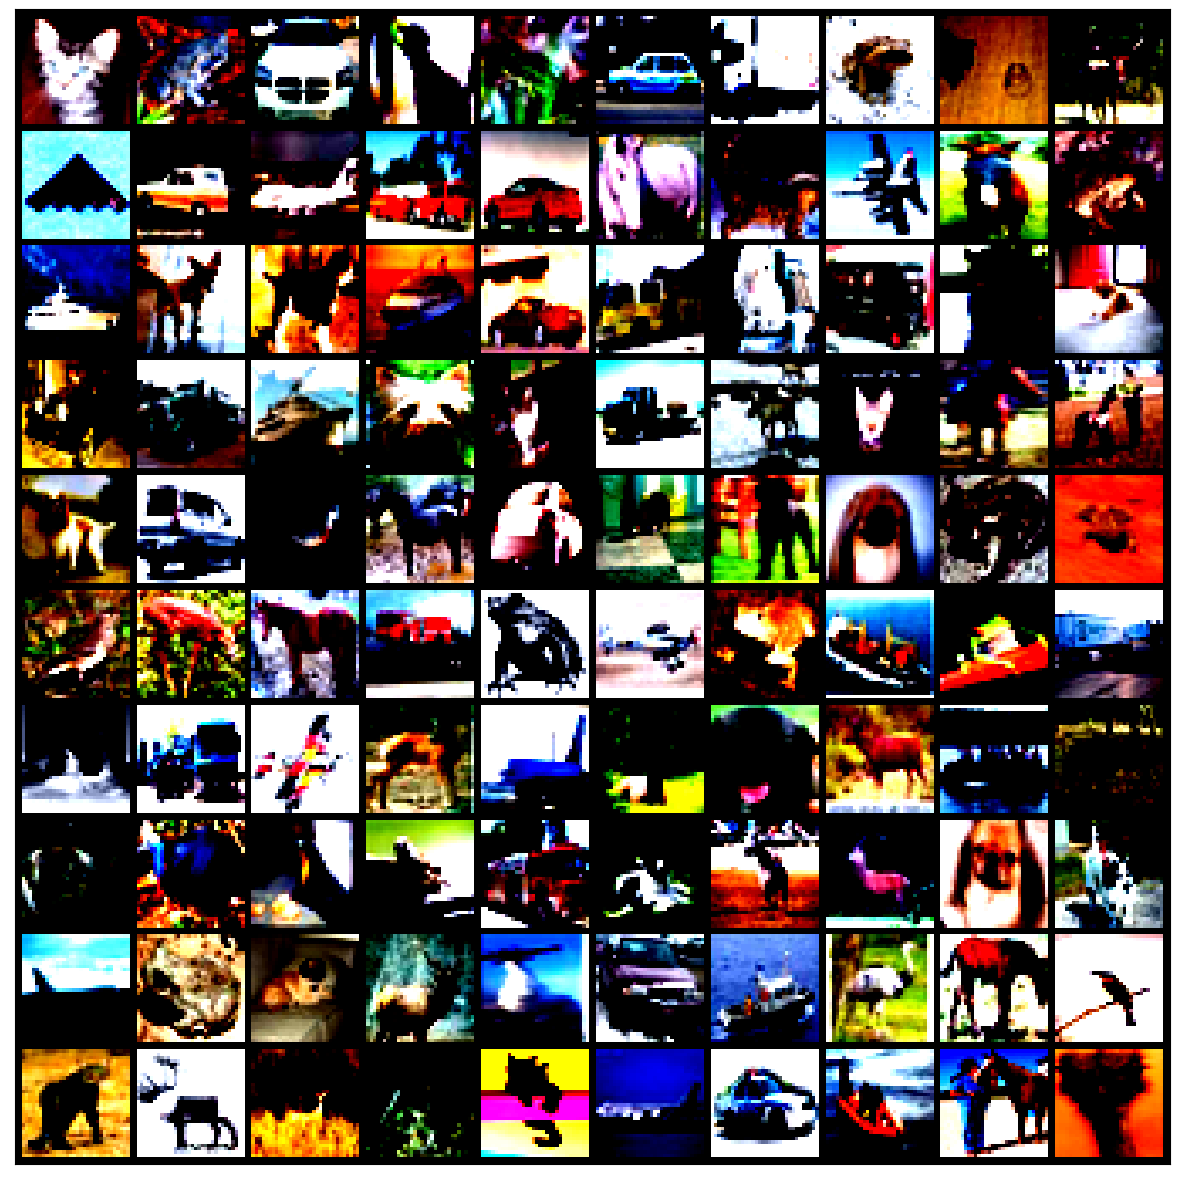

In [9]:
show_batch(train_loader)

In [10]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [11]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return float(correct)/total
    

In [12]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 



def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # forward pass
        y_pred = model(x.to(device))

        # for calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy 
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)
    

In [13]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
 
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc= validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        
        master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs


In [14]:
# TODO: write a function to calculate and return the confusion values
from sklearn.metrics import confusion_matrix
def calc_confusion_values(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    with torch.no_grad():  # Deactivate gradients for the following code
        for images, labels in dataloader:
            # Move tensor to the correct device
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass through the model
            outputs = model(images)
            # Get the predicted class
            _, predictions = torch.max(outputs, 1)
            # Save labels and predictions to calculate confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    # Calculate the confusion matrix
    confusion_values = confusion_matrix(all_labels, all_predictions)
    return confusion_values

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Logistic Regression   

In [15]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = torch.flatten(x, start_dim = 1)
        # TODO: run the data through the layer
        outputs = self.linear(x)
        return outputs

In [16]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
input_dim = 32*32*3
output_dim = 10
linear_regression = LR(input_dim, output_dim).to(device)
linear_regression.train()


LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [17]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [18]:
# TODO: define the loss function
loss_function = torch.nn.CrossEntropyLoss()

In [19]:
num_epochs = 20
## TODO: run training over 20 epochs
train_losses, val_losses, train_accs, val_accs = run_training(linear_regression, optimizer, loss_function, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)


Finished training after 340 seconds.


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

* Learning Complex Functions-  allows neural networks to approximate complex functions,
* Activation Thresholding: non-linearities like ReLU (Rectified Linear Unit) and its variants introduce activation thresholds- activate a neuron only if the input surpasses a certain threshold.
* Representation:  allows the network to learn complex patterns and representations.


In [21]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 1650)
        self.layer2 = torch.nn.Linear(1650, 512)
        self.layer3 = torch.nn.Linear(512, 138)
        self.layer4 = torch.nn.Linear(138, output_dim)
        self.activation = torch.nn.ReLU()
        
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input
        xb = torch.flatten(xb, start_dim=1)
        
        # Pass through the layers and apply activation function
        xb = self.activation(self.layer1(xb))
        xb = self.activation(self.layer2(xb))
        xb = self.activation(self.layer3(xb))
        xb = self.layer4(xb) # No activation function on the last layer


        return xb

In [22]:
## TODO: Define network, put it to device and train mode
multi_layer_p = MLP(input_dim, output_dim).to(device)
multi_layer_p.train()

MLP(
  (layer1): Linear(in_features=3072, out_features=1650, bias=True)
  (layer2): Linear(in_features=1650, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=138, bias=True)
  (layer4): Linear(in_features=138, out_features=10, bias=True)
  (activation): ReLU()
)

In [23]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(multi_layer_p.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

In [24]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20
## TODO: run training over 20 epochs
train_losses_2, val_losses_2, train_accs_2, val_accs_2 = run_training(multi_layer_p, optimizer, loss_function, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)


Finished training after 349 seconds.


## Add L2 regularisation

In [26]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
#  new instance of MLP
multi_layer_p_2 = MLP(input_dim, output_dim).to(device)

# Define the optimizer with weight decay for regularization
optimizer = torch.optim.Adam(multi_layer_p_2.parameters(), lr=0.001, weight_decay=0.0005)

In [27]:
multi_layer_p_2.train()

MLP(
  (layer1): Linear(in_features=3072, out_features=1650, bias=True)
  (layer2): Linear(in_features=1650, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=138, bias=True)
  (layer4): Linear(in_features=138, out_features=10, bias=True)
  (activation): ReLU()
)

In [28]:
## TODO: Retrain new model with regularization over 20 epochs
## TODO: Train the MLP over 20 epochs
num_epochs = 20
## TODO: run training over 20 epochs
train_losses_3, val_losses_3, train_accs_3, val_accs_3 = run_training(multi_layer_p_2, optimizer, loss_function, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)


Finished training after 350 seconds.


## LeNet5

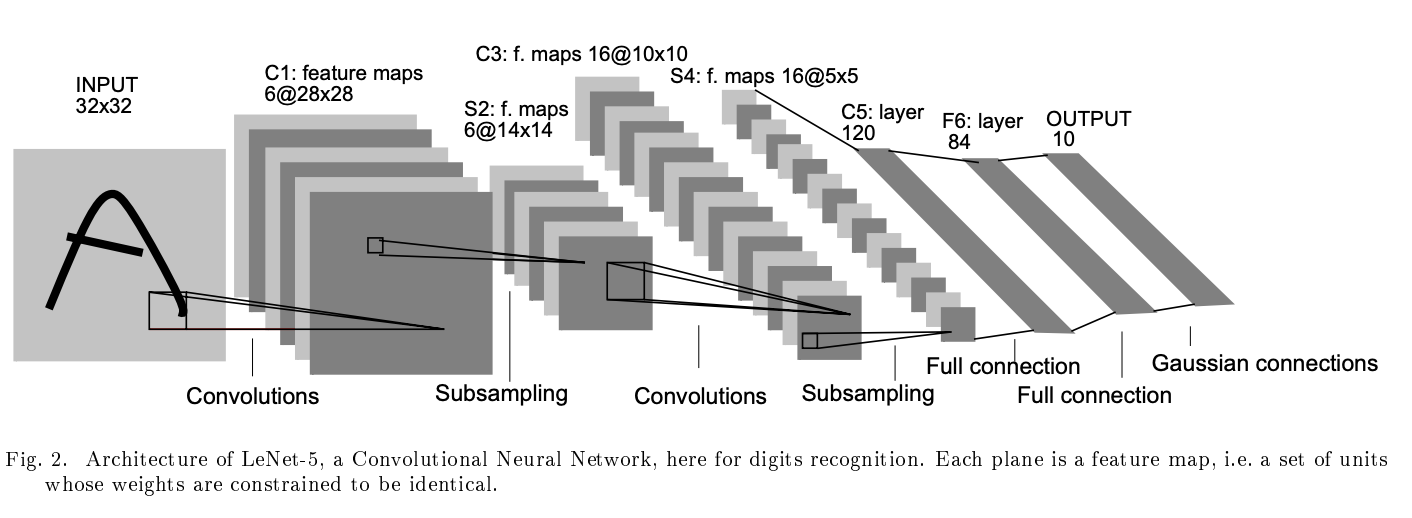

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [29]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),  # c5 layer
            nn.ReLU(),

        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [32]:
## TODO: define network, put it to the device and train mode
Lenet = LeNet5(10, 3).to(device)
Lenet.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [33]:
## TODO: define loss function and optimisers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Lenet.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [34]:
## TODO: train with 20 epochs
num_epochs = 20

train_losses_4, val_losses_4, train_accs_4, val_accs_4 = run_training(Lenet, optimizer, criterion, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)


Finished training after 364 seconds.


## Analysis 

In [35]:
results = {
    'LR': {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    },
    'MLP': {
        'train_loss': train_losses_2,
        'val_loss': val_losses_2,
        'train_acc': train_accs_2,
        'val_acc': val_accs_2
    },
     'MLP with Regularization':{
        'train_loss': train_losses_3,
        'val_loss': val_losses_3,
        'train_acc': train_accs_3,
        'val_acc': val_accs_3
         
    },
     'LeNet5': {
        'train_loss': train_losses_4,
        'val_loss': val_losses_4,
        'train_acc': train_accs_4,
        'val_acc': val_accs_4
    }
}

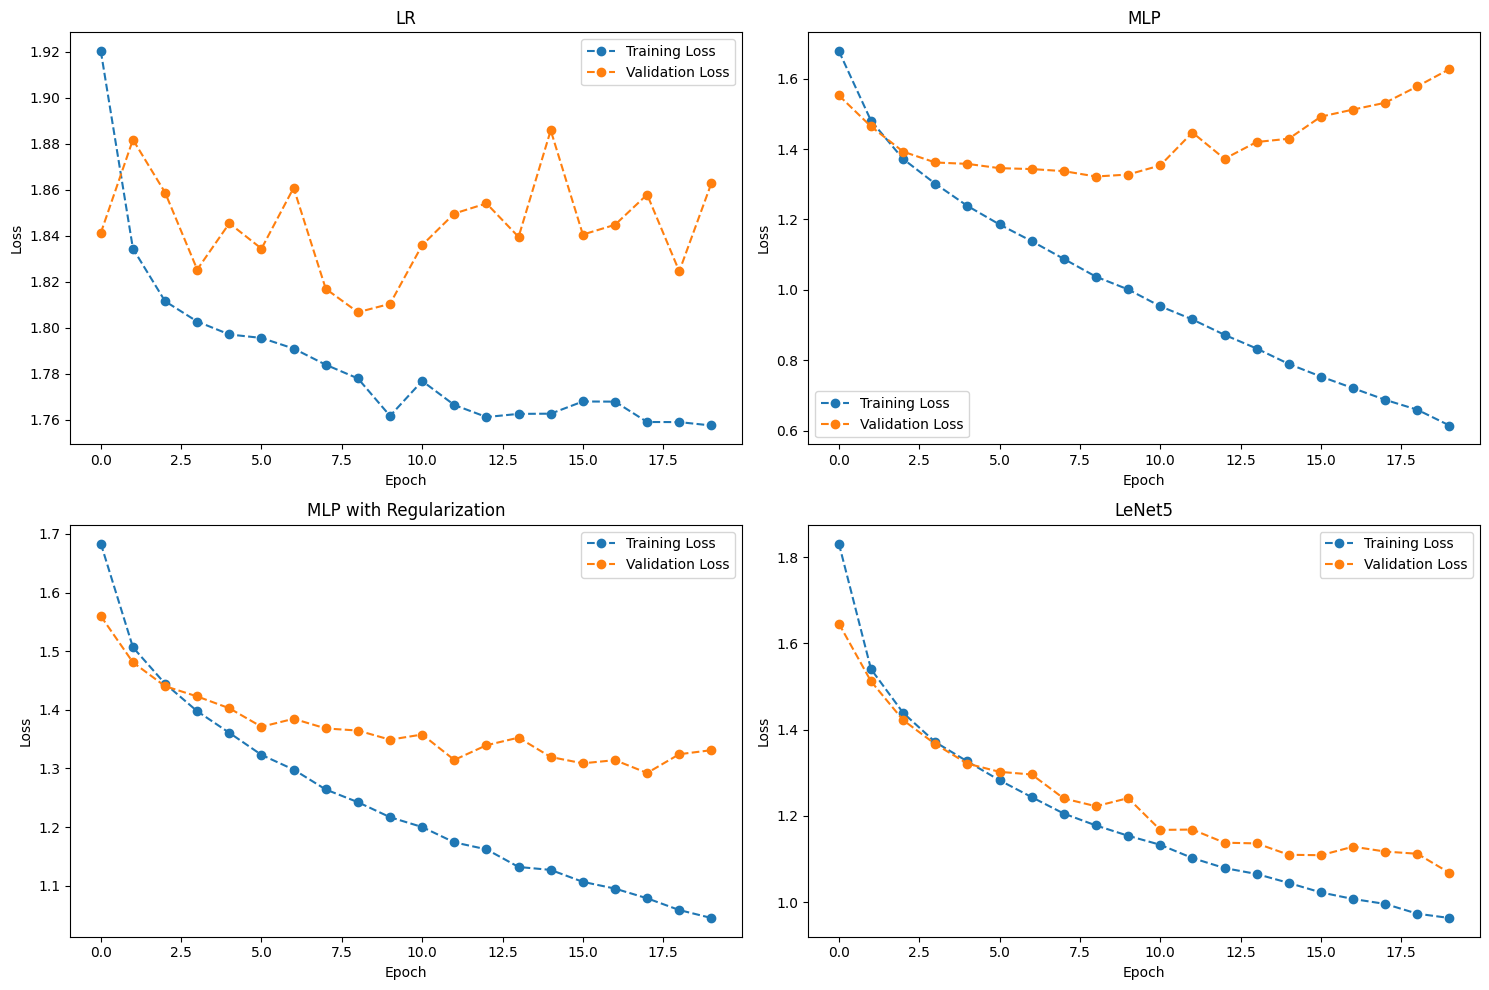

In [36]:
## TODO: Plot both train and val losses for all models. 
## What do you see?
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for i, (model_name, model_results) in enumerate(results.items()):
    axs[i].plot(model_results['train_loss'], '--o', label='Training Loss')
    axs[i].plot(model_results['val_loss'], '--o', label='Validation Loss')
    axs[i].set_title(model_name)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()


plt.tight_layout()
plt.show()

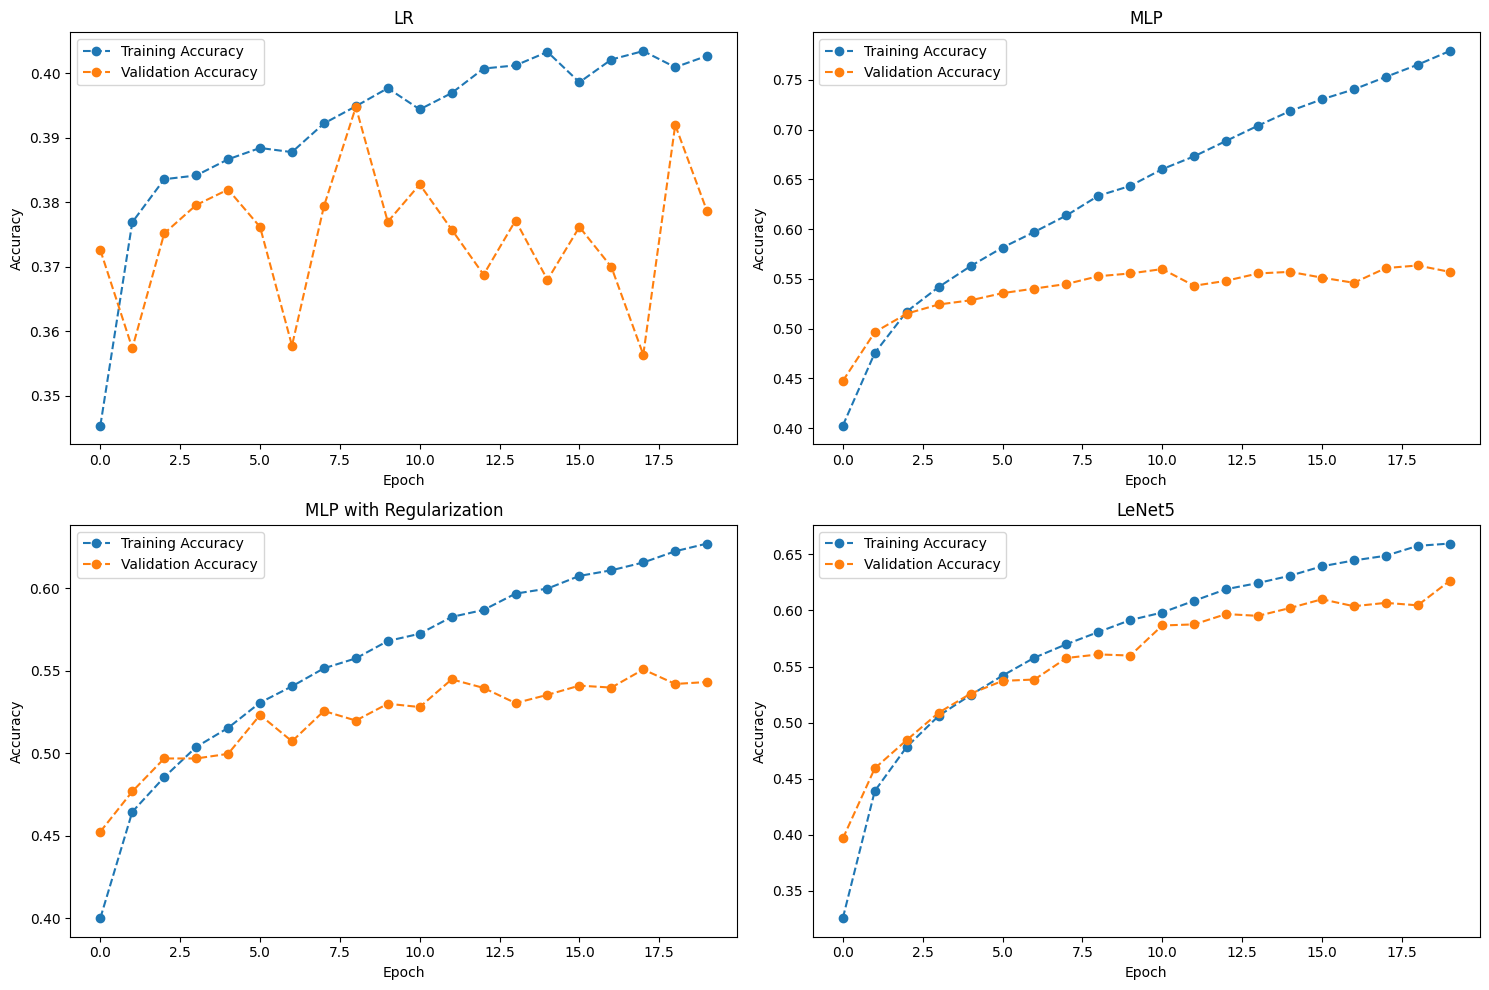

In [37]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for i, (model_name, model_results) in enumerate(results.items()):
    axs[i].plot(model_results['train_acc'], '--o', label='Training Accuracy')
    axs[i].plot(model_results['val_acc'], '--o', label='Validation Accuracy')
    axs[i].set_title(model_name)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()

plt.tight_layout()
plt.show()

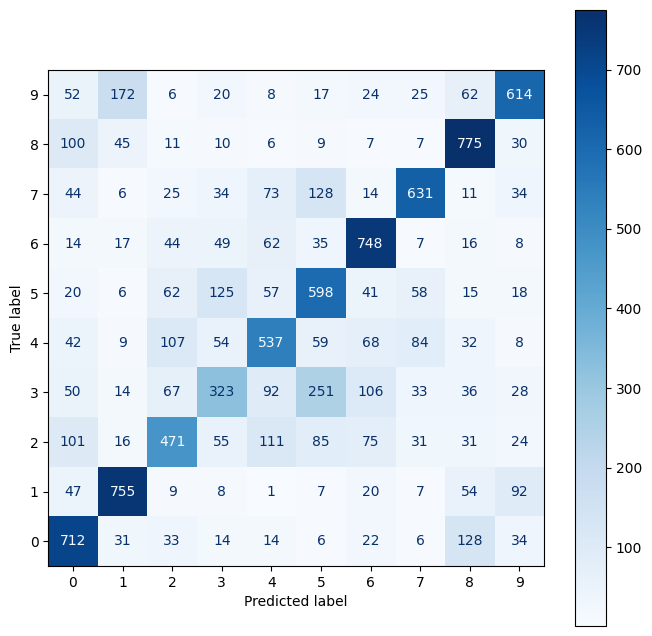

In [42]:
## TODO: Plot the confusion matrix for LeNet5
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(8,8))
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues, ax=ax)
    ax.invert_yaxis()
    plt.show()
    
# calculate confusion mat
confusion_values = calc_confusion_values(test_loader, Lenet, device)

# plot confusion mat
plot_confusion_matrix(confusion_values)

## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

1. Multi-Layer Perceptron (MLP) model slightly decreased its overall performance in terms of training loss and training accuracy. Regularization is generally used to improve the generalization ability of the model. However, it's important that regularization adds a penalty to the loss function to control the complexity of the model and prevent overfitting. This generally increases the training loss and might decrease training accuracy as well. If the model was overfitting before the addition of regularization, we might observe an increase in validation accuracy

2. Most confusion means, model is doing poor prediction between 0&8, 1&9, 2&4, 3&5

3. LR is the simplest model among the three and is not suitable for complex tasks like image classification, which is reflected in its lower performance in both loss and accuracy,# MLP, is a more complex model- can learn non-linear relationships, resulting in significantly better performance. # LeNet5, a CNN designed for image-based tasks thus it has better performance.

4. Convolutional layers are suited for image-based tasks because they take into account the spatial structure of a image. They consider the local correlation between pixels by using filters that scan the entire image, whereas fully connected layers (as used in LR and MLP) treat each pixel independently. Convolutional layers allows model to learn local features like edges or textures in early layers and global features like shapes or objects in deeper. 

5. Yes. Different model may require different optimization techniques: Some  might benefit more from an optimizer like SGD, while others might benefit more from optimizers like Adam or RMSprop etc, & the problem at hand, and the data. For example, Adam often works well on deeper networks because it utilizes adaptive learning rates. On the other hand optimizer instance for different models, or for retraining the same model, the optimizer might continue from the last state, which is problematic & could lead to unpredictable training results.
-  For loss, again yes, Multi-class classification tasks- we usually use Cross Entropy Loss. Multi-label classification tasks: BCE or variants of it can be used. But in training same model with same task, again with same loss function- not a problem! However, if we want to change the task, then differnent loss function is needed


## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
